In [360]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

plt.rcParams["text.usetex"]=True
plotdir = '/Users/GUSTO/Desktop/plots/'
datadir = '/Users/GUSTO/data/training/'

## Testing what input dimensionalities PyTorch CNN filters need

In [361]:
vec = np.ones((100, 100))
tens = torch.tensor(vec, dtype=torch.float32)


In [362]:
tens.shape

torch.Size([100, 100])

In [363]:
tens = tens.unsqueeze(0)
tens = tens.view(100, 1, 100)

In [364]:
m = nn.Conv1d(1, 1, 3, stride=1)
input = tens
output = m(input)

In [365]:
tens

tensor([[[1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.]],

        ...,

        [[1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.]]])

In [366]:
#tens = tens.squeeze()
torch.linalg.vector_norm(tens, dim = -1, keepdim = True)

tensor([[[10.]],

        [[10.]],

        [[10.]],

        [[10.]],

        [[10.]],

        [[10.]],

        [[10.]],

        [[10.]],

        [[10.]],

        [[10.]],

        [[10.]],

        [[10.]],

        [[10.]],

        [[10.]],

        [[10.]],

        [[10.]],

        [[10.]],

        [[10.]],

        [[10.]],

        [[10.]],

        [[10.]],

        [[10.]],

        [[10.]],

        [[10.]],

        [[10.]],

        [[10.]],

        [[10.]],

        [[10.]],

        [[10.]],

        [[10.]],

        [[10.]],

        [[10.]],

        [[10.]],

        [[10.]],

        [[10.]],

        [[10.]],

        [[10.]],

        [[10.]],

        [[10.]],

        [[10.]],

        [[10.]],

        [[10.]],

        [[10.]],

        [[10.]],

        [[10.]],

        [[10.]],

        [[10.]],

        [[10.]],

        [[10.]],

        [[10.]],

        [[10.]],

        [[10.]],

        [[10.]],

        [[10.]],

        [[10.]],

        [[

In [367]:
output

tensor([[[-0.8539, -0.8539, -0.8539,  ..., -0.8539, -0.8539, -0.8539]],

        [[-0.8539, -0.8539, -0.8539,  ..., -0.8539, -0.8539, -0.8539]],

        [[-0.8539, -0.8539, -0.8539,  ..., -0.8539, -0.8539, -0.8539]],

        ...,

        [[-0.8539, -0.8539, -0.8539,  ..., -0.8539, -0.8539, -0.8539]],

        [[-0.8539, -0.8539, -0.8539,  ..., -0.8539, -0.8539, -0.8539]],

        [[-0.8539, -0.8539, -0.8539,  ..., -0.8539, -0.8539, -0.8539]]],
       grad_fn=<ConvolutionBackward0>)

In [368]:
output.shape

torch.Size([100, 1, 98])

## Examining output from Dense and U-Net networks trained on 1D Poisson Eqn. data

In [369]:
from PyT_tinymodels import (OneD_UNet, Dense, LinReg, LinConv, smoother)

load models and state dictionaries:

In [370]:
device = (
            "cuda"
            if torch.cuda.is_available()
            else "mps"
            if torch.backends.mps.is_available()
            else "cpu"
        )

UNet = OneD_UNet(1,1).to(device)
UNet.load_state_dict(torch.load("/Users/GUSTO/environments/firedrake/src/gusto/learning/unet_poisson_trans.pth"))

dense = Dense().to(device)
dense.load_state_dict(torch.load("/Users/GUSTO/environments/firedrake/src/gusto/learning/poisson_trans.pth"))

linreg = LinReg().to(device)
linreg.load_state_dict(torch.load("/Users/GUSTO/environments/firedrake/src/gusto/learning/lin_poisson_trans.pth"))

linconv = LinConv().to(device)
linconv.load_state_dict(torch.load("/Users/GUSTO/environments/firedrake/src/gusto/learning/linconv_poisson_trans.pth"))

Smoother = smoother().to(device)

sm_kernel = torch.tensor([0.05, 0.075, 0.1, 0.175, 0.2, 0.175, 0.1, 0.075, 0.05], dtype=torch.float32)
smoother = lambda input: F.conv1d(input, sm_kernel.view(1, 1, -1), padding=4)

examine performance on standard input of RHS of ones:

In [375]:
vec = np.ones((100, 100))
vec *= 1/np.linalg.norm(vec, ord=np.inf, axis=-1, keepdims=True)
tens = torch.tensor(vec, dtype=torch.float32)

with torch.no_grad():
    out = dense(tens)
    out = torch.Tensor.numpy(out)
    out *= np.linalg.norm(vec, ord=np.inf, axis=-1, keepdims=True)
    out = torch.tensor(out, dtype=torch.float32)
    out = out.unsqueeze(1)
    #print(out.shape)
    out = smoother(out)
    out = smoother(out)
    out = out.squeeze(1)
    lin_out = linreg(tens)
    lin_out = lin_out.unsqueeze(1)
    lin_out = smoother(lin_out)
    lin_out = smoother(lin_out)
    lin_out = lin_out.squeeze(1)
    
Dense_out = torch.Tensor.numpy(out)
lin_out = torch.Tensor.numpy(lin_out)
lin_out *= np.linalg.norm(vec, ord=np.inf, axis=-1, keepdims=True)

tens = tens.unsqueeze(1)
UNet.eval()
with torch.no_grad():
    out = UNet(tens)
    out = out.squeeze(1)
    linconv_out = linconv(tens)
    linconv_out = linconv_out.squeeze()
UNet_out = torch.Tensor.numpy(out)
UNet_out *= np.linalg.norm(vec, ord=np.inf, axis=-1, keepdims=True)

linconv_out = torch.Tensor.numpy(linconv_out)
linconv_out *= np.linalg.norm(vec, ord=np.inf, axis=-1, keepdims=True)

The performance of the U-Net is appaling. The dense network is somewhat okay after adding some smoothing with a fairly broad filter.

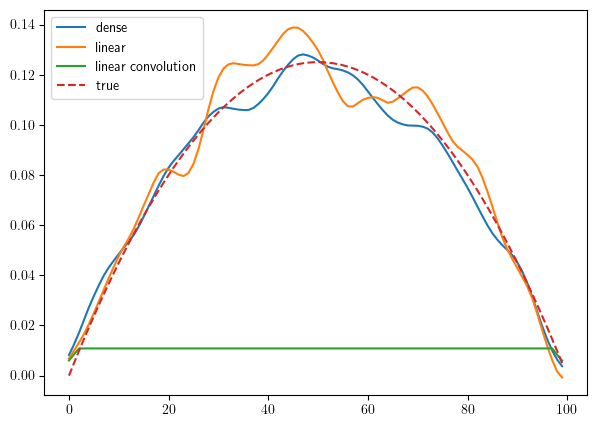

In [376]:
xs = np.arange(100, step=1)
test = (- xs **2 + 100*xs)*0.00005
#plt.plot(UNet_out[0], label = 'UNet')
plt.plot(Dense_out[0], label = 'dense')
plt.plot(lin_out[0],  label = 'linear')
plt.plot(linconv_out[0],  label = 'linear convolution')
plt.plot(test, '--', label = 'true')
plt.legend()

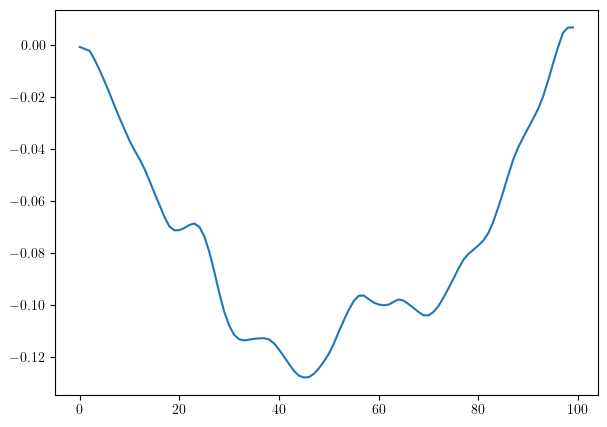

In [377]:
plt.plot(linconv_out[0] - lin_out[0])

#### Here is why random RHS vectors for training do not work well 
It's just noise and there are no patterns to learn. Additionally, soln becomes tiny compared to RHS.

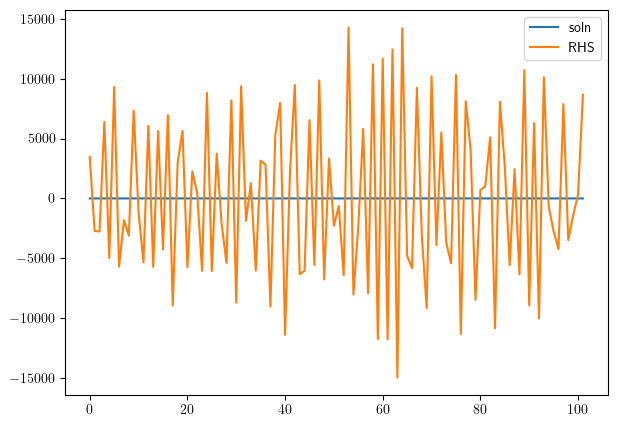

In [378]:
matrix = (2*np.eye(102) - np.eye(102, k=-1) - np.eye(102, k=1))*100**2
#matrix[-1][0] = -1
#matrix[0][-1] = -1
vec_out = np.random.rand(1000, 102)
vec_in = np.dot(vec_out, matrix)
plt.plot(vec_out[0], label = 'soln')
plt.plot(vec_in[0], label = 'RHS')
plt.legend()

## Generating smooth training data
Simple superposition of sines

In [379]:
xs = np.arange(102, step=1)
a = 0.1 * np.random.randn(1000)
b = 0.05 * np.random.randn(1000)
c = 0.03 * np.random.randn(1000)
d = 0.03 * np.random.randn(1000)
vec_out = np.zeros((1000, 102))
for i in np.arange(1000):
    vec_out[i] = (a[i] * np.sin(np.pi/100 * xs) + b[i] * np.sin(np.pi/100 * 2 * xs) + 
               c[i] * np.sin(np.pi/100 * 3 * xs) + d[i] * np.sin(np.pi/100 * 4 * xs))
    
vec_in = np.dot(vec_out, matrix)

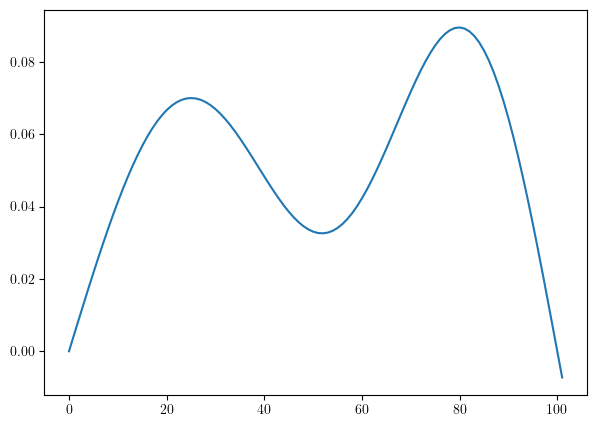

In [380]:
plt.plot(vec_out[1])

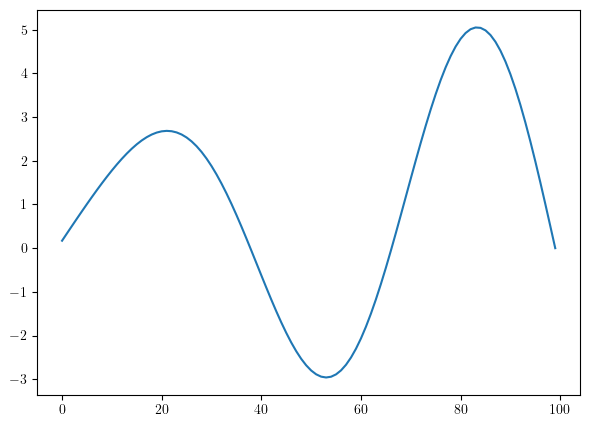

In [381]:
plt.plot(vec_in[1][1:-1])

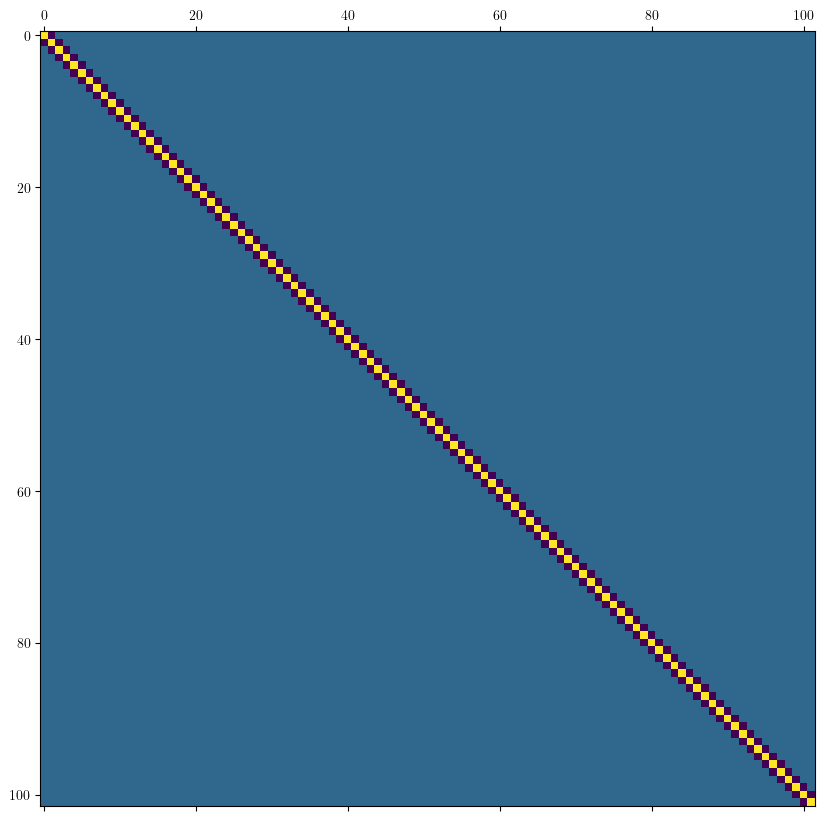

In [382]:
plt.rcParams["figure.figsize"] = [10, 10]
plt.matshow(matrix)
plt.rcParams["figure.figsize"] = [7, 5]

The below is just to check the solution vector obtained from a constant RHS of ones

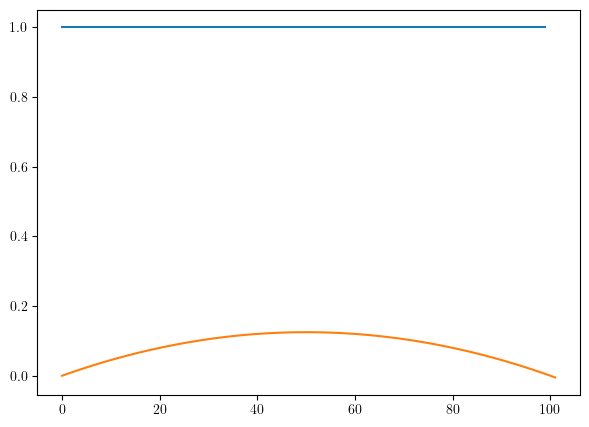

In [383]:
test = (- xs **2 + 100*xs)*0.00005
plt.plot(np.dot(test, matrix)[1:-1])
plt.plot(test)

Need to cut off the sides of the vectors because somehow they like shooting off to large values - improperly specified BCs in the matrix?

In [384]:
vec_in = vec_in[:, 1:-1]
vec_out = vec_out[:, 1:-1]

In [385]:
vec_in.shape

(1000, 100)

Let's just check model performance on signal drawn from the distribution that generated its training data (i.e. sine wave superposition):

In [386]:
#apply input scaling
norm = np.linalg.norm(vec_in, np.inf, axis = 1, keepdims = True)
vec_in *= 1/norm

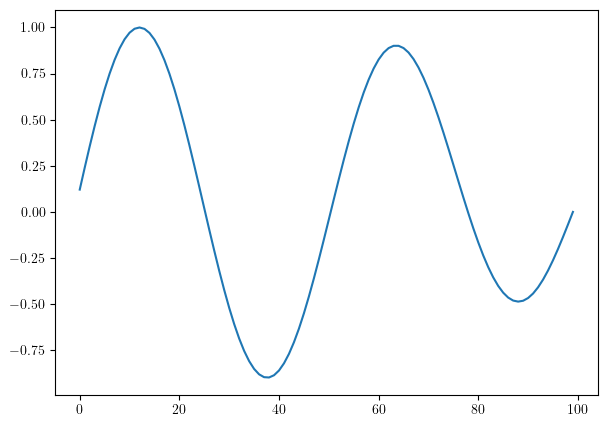

In [387]:
plt.plot(vec_in[0])

In [388]:
tens = torch.tensor(vec_in, dtype=torch.float32)
tens = tens.unsqueeze(1)
UNet.eval()
with torch.no_grad():
    out = UNet(tens)
out = out.squeeze(1)
UNet_out = torch.Tensor.numpy(out)
UNet_out *= norm/1


with torch.no_grad():
    out = linconv(tens)
out = out.squeeze(1)
linconv_out = torch.Tensor.numpy(out)
linconv_out *= norm/1


tens = torch.tensor(vec_in, dtype=torch.float32)
with torch.no_grad():
    out = dense(tens)
    out = out.unsqueeze(1)
    out = smoother(out)
    out = smoother(out)
    out = out.squeeze(1)
Dense_out = torch.Tensor.numpy(out)
Dense_out *= norm/1

with torch.no_grad():
    out = linreg(tens)
    out = out.unsqueeze(1)
    out = smoother(out)
    out = smoother(out)
    out = out.squeeze(1)
linreg_out = torch.Tensor.numpy(out)
linreg_out *= norm/1


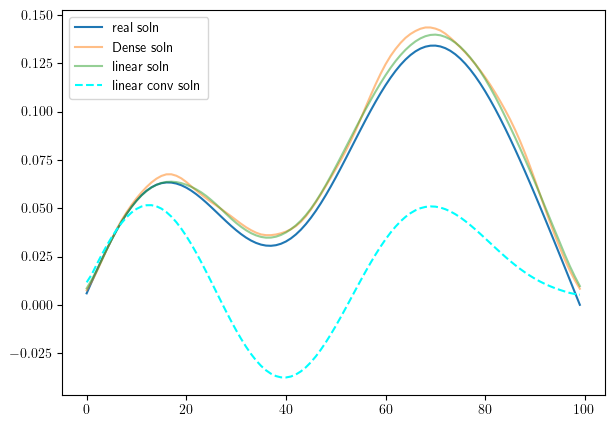

In [393]:
fig, ax = plt.subplots()
s = 100
ax.plot(vec_out[s], label = 'real soln')
#ax.plot(UNet_out[s], label = 'U-Net soln', alpha = 0.5)
ax.plot(Dense_out[s], label = 'Dense soln', alpha = 0.5)
ax.plot(linreg_out[s], label = 'linear soln', alpha = 0.5)
ax.plot(linconv_out[s], '--', label = 'linear conv soln', color = 'cyan')

ax.legend()

In [394]:
mse = torch.nn.MSELoss()

In [395]:
mse(torch.tensor(vec_in[0], dtype=torch.float32), torch.tensor(UNet_out[0], dtype=torch.float32))

tensor(2.1755)

## Why is GCR still not converging despite the dense model's outputs looking reasonable-ish?

To try and find out if this is now just a maths issue or if there is something wrong with my code, I output vectors from the solve at the following points:

- In MLCtx.mult(), we write the input vectors to ``ml_invecs.txt`` and the output vectors to ``ml_outvecs.txt``
- In Laplace1D.mult(), we again write the input vectors to ``lapl_invecs.txt``and the output vectors to ``lapl_outvecs.txt``.

This outputting only happens if we pass the ``-info`` flag when executing.

From Ackmann et al. (2020), we expect GCR to work like this (where the system to be solved is $\mathcal{L} \Phi = R$):

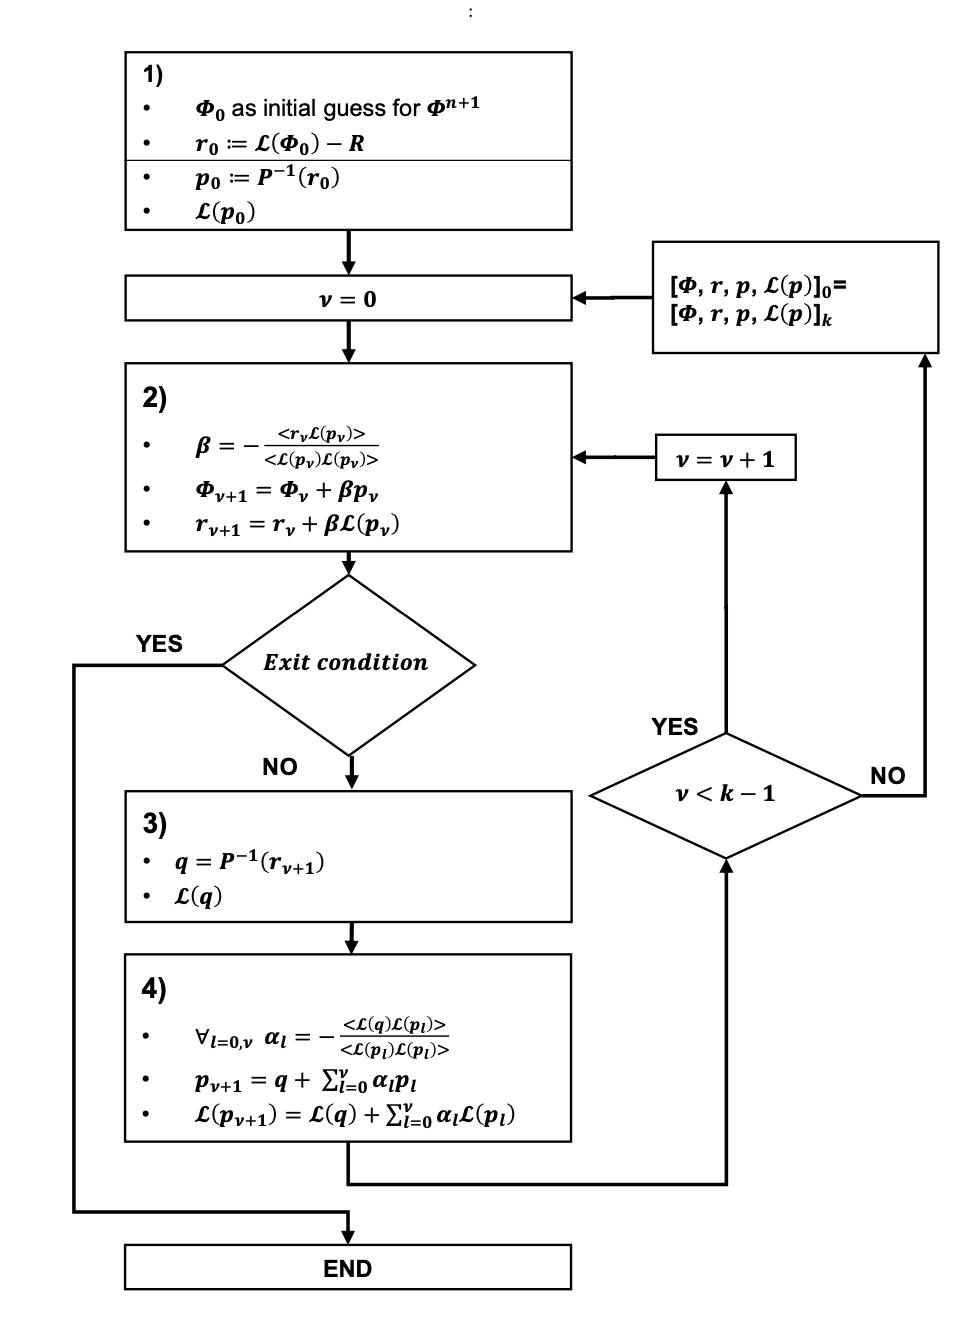


Wo we expect the first input to the laplacian to be some first guess (maybe just zeros) and the first input to the ML model the result of that guess minus the RHS. For reference, the RHS used for this run is just a vector of ones. 

In [277]:
datadir = '/Users/GUSTO/data/debug/'
exp = 'ml_dense/'
ml_invecs = np.loadtxt(datadir + exp + 'prec_invecs.txt', delimiter=',')
ml_outvecs = np.loadtxt(datadir + exp + 'prec_outvecs.txt', delimiter=',')
lapl_invecs = np.loadtxt(datadir + exp + 'lapl_invecs.txt', delimiter=',')
lapl_outvecs = np.loadtxt(datadir + exp + 'lapl_outvecs.txt', delimiter=',')

/var/folders/7d/t77vrt9n6y1g0vprtd5ds0140000gq/T/ipykernel_78935/759157878.py:3: UserWarning: loadtxt: input contained no data: "/Users/GUSTO/data/debug/ml_dense/prec_invecs.txt"
  ml_invecs = np.loadtxt(datadir + exp + 'prec_invecs.txt', delimiter=',')
/var/folders/7d/t77vrt9n6y1g0vprtd5ds0140000gq/T/ipykernel_78935/759157878.py:4: UserWarning: loadtxt: input contained no data: "/Users/GUSTO/data/debug/ml_dense/prec_outvecs.txt"
  ml_outvecs = np.loadtxt(datadir + exp + 'prec_outvecs.txt', delimiter=',')
/var/folders/7d/t77vrt9n6y1g0vprtd5ds0140000gq/T/ipykernel_78935/759157878.py:5: UserWarning: loadtxt: input contained no data: "/Users/GUSTO/data/debug/ml_dense/lapl_invecs.txt"
  lapl_invecs = np.loadtxt(datadir + exp + 'lapl_invecs.txt', delimiter=',')
/var/folders/7d/t77vrt9n6y1g0vprtd5ds0140000gq/T/ipykernel_78935/759157878.py:6: UserWarning: loadtxt: input contained no data: "/Users/GUSTO/data/debug/ml_dense/lapl_outvecs.txt"
  lapl_outvecs = np.loadtxt(datadir + exp + 'lapl_out

As a sanity check, let's see what length the datasets have. We expect that at each iteration, the ML model does one inference on the residual, the output of which is then passed to the Laplacian, and that result should be used several times at that iterate (does not need to be recomputed). In addition, the Laplacian is applied once in the beginning to compute the initial residual. We therefore expect the laplacian files to be exactly one entry longer than the ML precon files.

In [1077]:
print('num. of vectors in ML input file: ', len(ml_invecs))
print('num. of vectors in ML output file: ', len(ml_outvecs))
print('num. of vectors in Laplacian input file: ', len(lapl_invecs))
print('num. of vectors in Laplacian input file: ', len(lapl_outvecs))

num. of vectors in ML input file:  0
num. of vectors in ML output file:  0
num. of vectors in Laplacian input file:  0
num. of vectors in Laplacian input file:  0


This seems like the Laplacian is maybe applied additionally once at the end of the run. Strange, but we won't worry too much for now...

The first input to the laplacian is indeed a vector of zeros, which naturally means the first output is as well:

In [ ]:
lapl_invecs[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

...so we'd expect the first input to the ML model to be a vector of -1s:

In [ ]:
ml_invecs[0]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

Hm! They're ones. Maybe this implementation of GCR works a little differently from Ackmann et al.'s?

Anyway! Is at least the output of the ML model in subsequent iterations equal to the input of the Laplacian?

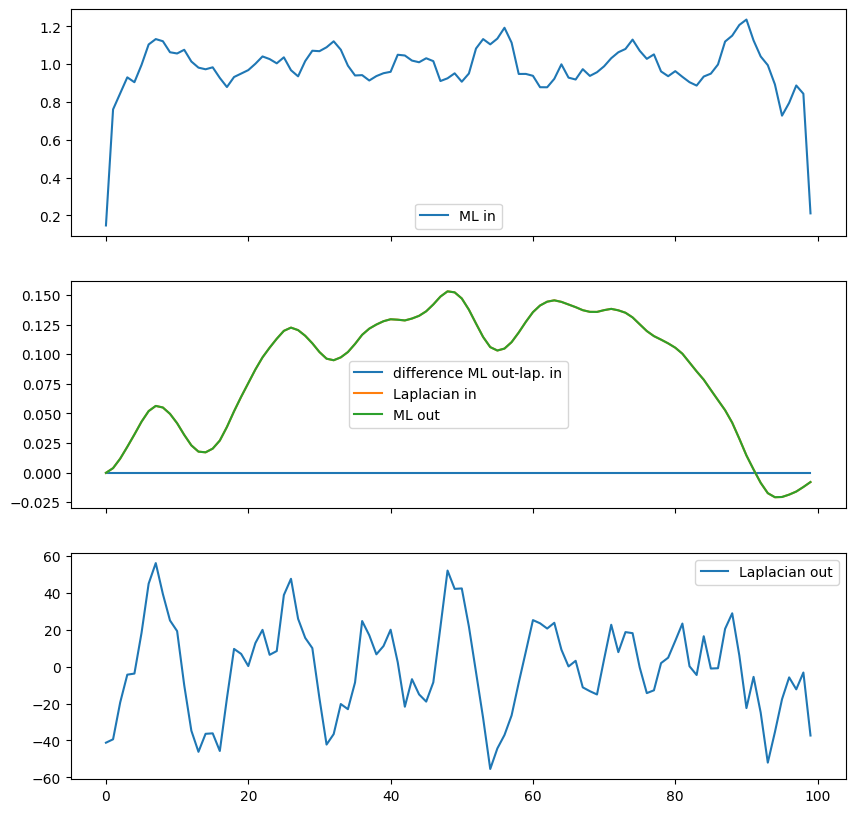

In [ ]:
it = 4
fig, ax = plt.subplots(3,1, sharex = True, figsize = (10, 10))
ax[1].plot(ml_outvecs[it] - lapl_invecs[it+1], label = 'difference ML out-lap. in')
ax[1].plot(lapl_invecs[it+1], label = 'Laplacian in')
ax[1].plot(ml_outvecs[it], label = 'ML out')
ax[1].legend()

ax[0].plot(ml_invecs[it], label = 'ML in')
ax[2].plot(lapl_outvecs[it+1], label = 'Laplacian out')
ax[0].legend()
ax[2].legend()

If the Laplacian iterate is off-set by one to account for the fact it's applied an extra time in the beginning, the ML output and the Laplacian input are exactly the same, which is what we want. A striking feature is that the iterations seem quite similar to one another; subsequent inputs to the ML model are not exactly a vector of ones, but it is a vector that hovers around one.

(N.B. the figure is set such that it mimics the flow of the solver in any single iteration: ML input -> ML output -> Laplacian input -> Laplacian output; the input to the next iteration is then a linear combination of the previous input and the previous laplacian output scaled by a factor $\beta$).

How does the input to the ML model (if PETSc's GCR works like Ackmann et al.'s, that's the residual) change between iterations? Does the average af that residual decrease at all in further iterations?

Text(0.5, 1.0, 'L2-norms of resid. with iterations')

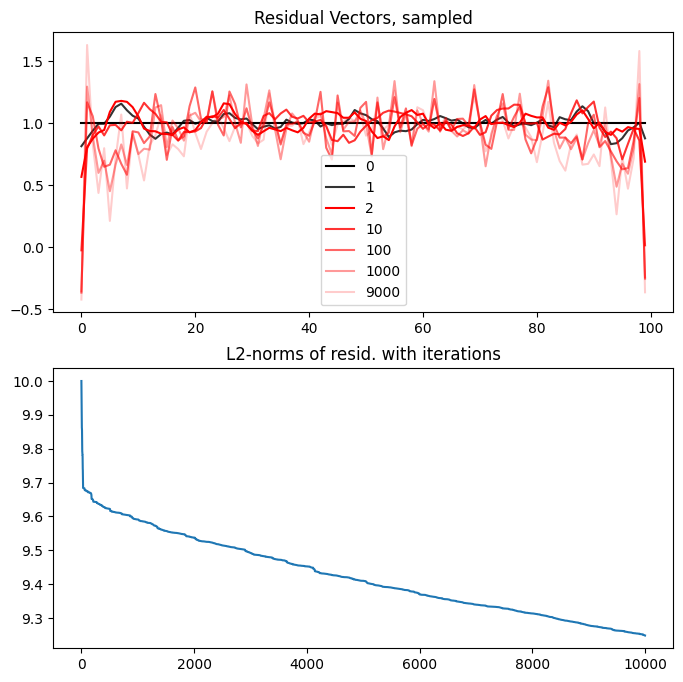

In [ ]:
fig, ax = plt.subplots(2,1, figsize = (8, 8))

ax[0].plot(ml_invecs[0], color = 'black', label = '0')
ax[0].plot(ml_invecs[1], color = 'black', alpha = 0.8, label = '1')
ax[0].plot(ml_invecs[2], color = 'red', label = '2')
ax[0].plot(ml_invecs[10], color = 'red', alpha = 0.8, label = '10')
ax[0].plot(ml_invecs[100], color = 'red', alpha = 0.6, label = '100')
ax[0].plot(ml_invecs[1000], color = 'red', alpha = 0.4, label = '1000')
ax[0].plot(ml_invecs[9000], color = 'red', alpha = 0.2, label = '9000')
ax[0].set_title('Residual Vectors, sampled')
ax[0].legend()

#compute L2-norms for all residuals
L2_mlinvecs = np.zeros(10000)
for i in range(10000):
    L2_mlinvecs[i] = np.linalg.norm(ml_invecs[i])

ax[1].plot(L2_mlinvecs)
ax[1].set_title('L2-norms of resid. with iterations')

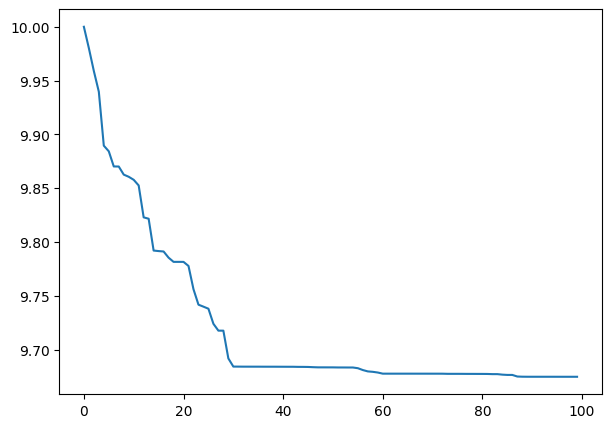

In [ ]:
plt.plot(L2_mlinvecs[:100])

The offshoots to the sides seem to become more pronounced at further iterations, and the noise seems to increase in magnitude very slightly with further iterations - but not by very much. The L2 norm of the residual does get smaller with further iterations though!! That's good news.

To better understand what is happening here, it might be instructive to run this with Jacobi as well (although I've noticed Jacobi does not seem to change the results at all compared to using no preconditioner).

In [ ]:
exp = 'jacobi/'
jac_invecs = np.loadtxt(datadir + exp + 'prec_invecs.txt', delimiter=',')
jac_outvecs = np.loadtxt(datadir + exp + 'prec_outvecs.txt', delimiter=',')
lapl_jac_invecs = np.loadtxt(datadir + exp + 'lapl_invecs.txt', delimiter=',')
lapl_jac_outvecs = np.loadtxt(datadir + exp + 'lapl_outvecs.txt', delimiter=',')

print('num. of vectors in Jacobi input file: ', len(jac_invecs))
print('num. of vectors in Jacobi output file: ', len(jac_outvecs))
print('num. of vectors in Laplacian input file: ', len(lapl_jac_invecs))
print('num. of vectors in Laplacian input file: ', len(lapl_jac_outvecs))

num. of vectors in Jacobi input file:  795
num. of vectors in Jacobi output file:  795
num. of vectors in Laplacian input file:  797
num. of vectors in Laplacian input file:  797


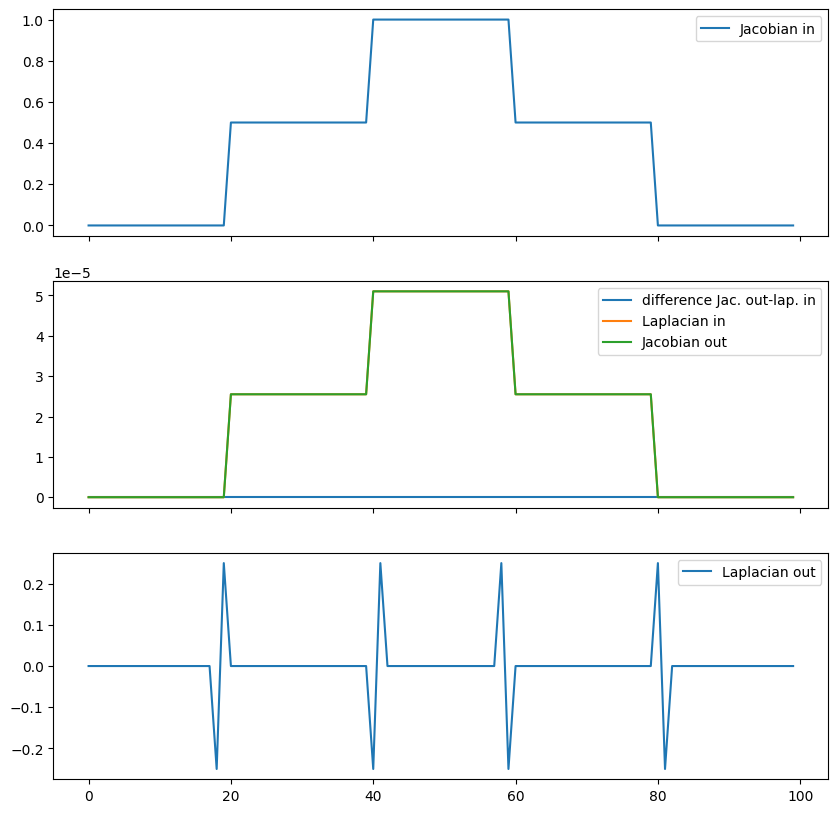

In [ ]:
it = 40
fig, ax = plt.subplots(3,1, sharex = True, figsize = (10, 10))
#somehow, we need to off-set the Laplacian data by two to get the input and output to match. So here laplacian is called another moot time?
ax[1].plot(jac_outvecs[it] - lapl_jac_invecs[it+1], label = 'difference Jac. out-lap. in')
ax[1].plot(lapl_jac_invecs[it+1], label = 'Laplacian in')
ax[1].plot(jac_outvecs[it], label = 'Jacobian out')
ax[1].legend()

ax[0].plot(jac_invecs[it], label = 'Jacobian in')
ax[2].plot(lapl_jac_outvecs[it+2], label = 'Laplacian out')
ax[0].legend()
ax[2].legend()

Here, it looks like the solver finds the solution by 'sweeping' along places where there are jumps in the residual. It also becomes apparent why this 'Jacobi' does not change the convergence of the solver in the slightest: all it does is to scale the residual, it doesn't change its direction - so the effect of the preconditioner is 'normalised away' when computing the step size at each solver iteration. Looking up Jacobi again and comparing with the PETSc python implementation, it seems like they forgot to implement the application of $L+U$ on the residual $r$: their implementation is 

$$ q = D^{-1}r $$

while it should be

$$ q = D^{-1}(R - (L + U)r) $$

So let's treat this as an unpreconditioned problem.

The next thing to try and see how we can make the ML model better is to train a linear regression model on this exact problem (so just a dataset of mapping RHSs of ones to the true solution) in the hopes that this will find the true inverse of the Laplacian (plots above suggest it does not - it does very well on that particular problem, but is horrendous on everything else. To get the true inverse, you'd have to get the training loss to exactly zero). Compare the residual convergence of unpreconditioned ('Jacobi') GCR with that preconditioned by the dense network and the linear regression model:

In [ ]:
#compute L2-norms for all residuals
L2_jacinvecs = np.zeros(10000)
for i in range(795):
    L2_jacinvecs[i] = np.linalg.norm(jac_invecs[i])

exp = 'ml_linreg/'
lin_invecs = np.loadtxt(datadir + exp + 'prec_invecs.txt', delimiter=',')
lin_outvecs = np.loadtxt(datadir + exp + 'prec_outvecs.txt', delimiter=',')
lapllin_invecs = np.loadtxt(datadir + exp + 'lapl_invecs.txt', delimiter=',')
lapllin_outvecs = np.loadtxt(datadir + exp + 'lapl_outvecs.txt', delimiter=',')

L2_lininvecs = np.zeros(10000)
for i in range(10000):
    L2_lininvecs[i] = np.linalg.norm(lin_invecs[i])

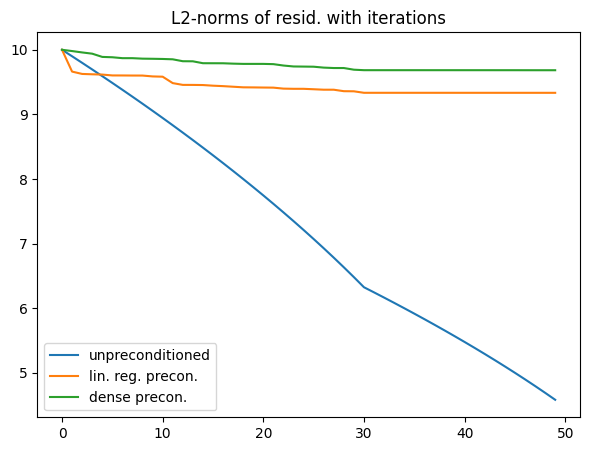

In [ ]:
plt.plot(L2_jacinvecs[:50], label = 'unpreconditioned')
plt.plot(L2_lininvecs[:50], label = 'lin. reg. precon.')
plt.plot(L2_mlinvecs[:50], label = 'dense precon.')
#plt.yscale('log')
plt.title('L2-norms of resid. with iterations')
plt.legend()

The linear model manages to beat unpreconditioned GCR at least on the first iteration, but after that the 'convergence' behaviour is very similar. Given how good the linear model is on the RHS of ones, I would have expeced a much bigger reduction in the residual though. 
 
To find out what is going wrong where, the next step is to retrace the GCR algorithm by hand. As an extra aid in addition to the flow chart above, the MO algorithm looks like this (taken from L1285 onwards of infrastructure/source/solver/iterative_solver_mod.F90):

In [ ]:
! initial guess
call dx%set_scalar(0.0_r_def)
call self%prec%apply( b, dx )
call self%lin_op%apply( dx, Ax )
! res = b - Ax
call res%copy(b)
call res%axpy(-1.0_r_def, Ax)

allocate(v(self%gcrk), source=x)
allocate(Pv(self%gcrk), source=x)

! initialisation complete, lets go to work.
do iter = 1, self%max_iter
    do iv = 1, self%gcrk
        ! apply the preconditioner
        call self%prec%apply( res, Pv(iv) )
        ! apply the operator
        call self%lin_op%apply( Pv(iv), v(iv) )
        do ivj = 1, iv-1
          alpha = v(iv)%dot(v(ivj))
          call v(iv)%axpy(-alpha, v(ivj))
          call Pv(iv)%axpy(-alpha, Pv(ivj))
        end do
        alpha = v(iv)%norm()
        beta  = 1.0_r_def/alpha
        call v(iv)%scale(beta)
        call Pv(iv)%scale(beta)
        alpha = res%dot(v(iv))
        call dx%axpy(alpha, Pv(iv))
        call res%axpy(-alpha, v(iv))
        if ( self%monitor_convergence ) then
          err = res%norm()/sc_err
          iv_final = iv
          if (err < self%r_tol ) exit
        end if
    end do
end do

Now translate this into Python, output at every step and compare with what we get from PETSc. First the initialisation step (after defining the linear and preconditioner operators):

In [540]:
Lapl = (2*np.eye(100) - np.eye(100, k=-1) - np.eye(100, k=1))*101**2
def pc_dense(x):
    #norm = np.linalg.norm(x, np.inf)
    #x *= 1/norm
    b = torch.tensor(x, dtype=torch.float32)
    with torch.no_grad():
        dx = dense(b)
        dx = dx.unsqueeze(0)
        dx = smoother(dx)
        dx = smoother(dx)
        dx = dx.squeeze()
    dx = torch.Tensor.numpy(dx)
    #dx *= norm
    return dx

def pc_lin(x):
    #norm = np.linalg.norm(x, np.inf)
    #x *= 1/norm
    b = torch.tensor(x, dtype=torch.float32)
    with torch.no_grad():
        dx = linreg(b)
        dx = dx.unsqueeze(0)
        dx = smoother(dx)
        dx = smoother(dx)
        dx = dx.squeeze()
    dx = torch.Tensor.numpy(dx)
    #dx *= norm
    return dx

def pc_linconv(x):
    #norm = np.linalg.norm(x, np.inf)
    #x *= 1/norm
    b = torch.tensor(x, dtype=torch.float32)
    b = b.unsqueeze(0)
    with torch.no_grad():
        dx = linconv(b)
        dx = dx.squeeze()
    dx = torch.Tensor.numpy(dx)
    #dx *= norm
    return dx


In [541]:
b = np.ones(100)
dx = pc_dense(b)
Ax = np.dot(dx, Lapl)
r = b-Ax

# set vectors up for a restart value of 3000
v = np.zeros((3000, 100))
Pv = np.zeros((3000, 100))

#array to store residuals in 
rs = np.zeros((3000, 100))

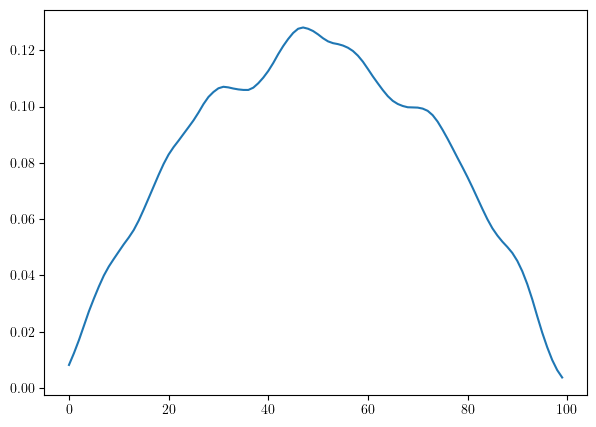

In [542]:
plt.plot(dx)

Check against data:

In [520]:
print(sum(dx - ml_outvecs[0]))
print(sum(Ax - lapl_outvecs[1]))

IndexError: index 0 is out of bounds for axis 0 with size 0

Now we know that works, define the full (non-restarted) GCR, both from the MO code and from scratch as in Eisenstat (1983):

To test the preconditioning setup, we also artificially construct a series of almost-perfect preconditioners from the true inverse, as well as a Neumann series approximation preconditioner:

In [543]:
#make different versions of 'near-perfect' pc that all result in similar residual magnitude. 
Ainv = np.linalg.inv(Lapl)

P_diag = Ainv.copy()
mask = (np.ones((100, 100)) - np.eye(100) - np.eye(100, k=1) - np.eye(100, k=2) - np.eye(100, k=3)   
         - np.eye(100, k=-3) - np.eye(100, k=-2) - np.eye(100, k=-1))
P_diag[mask.astype(bool)] = P_diag[mask.astype(bool)]*0.2
P_diag=P_diag*3.25
P_diag+=8e-6
#plt.imshow(P_diag)

P_dense = Ainv.copy()
mask = (np.ones((100, 100)) - np.eye(100) - np.eye(100, k=1) - np.eye(100, k=2) - np.eye(100, k=3)   
         - np.eye(100, k=-3) - np.eye(100, k=-2) - np.eye(100, k=-1))
P_dense[mask.astype(bool)] = P_dense[mask.astype(bool)]*0.95
P_dense=P_dense*1.05
P_dense+=5e-6
#plt.imshow(P_diag)

P_noise = Ainv.copy()
P_noise += np.random.randn(100,100)*0.03*P_noise

P_sines = Ainv.copy()
for i in range(100):
    P_sines[i] += np.average(P_sines)* (0.2*np.sin((2*np.pi)/100*i) + 0.2*np.cos(2*(2*np.pi)/100*i) - 0.2*np.sin(3*(2*np.pi)/100*i)
                               - 0.2*np.cos(5.5*(2*np.pi)/100*i))

#Neumann series approx
D = np.diag(Lapl)
Dinv = 1/D * np.eye(100)
#LU = D*np.eye(100) - Lapl
P_nm = Dinv@(np.eye(100) + (np.eye(100) - Dinv@Lapl) + np.linalg.matrix_power(np.eye(100) - Dinv@Lapl, 2) +
              np.linalg.matrix_power(np.eye(100) - Dinv@Lapl, 3))

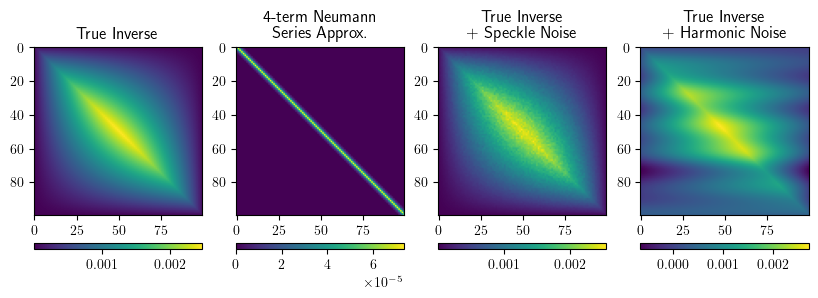

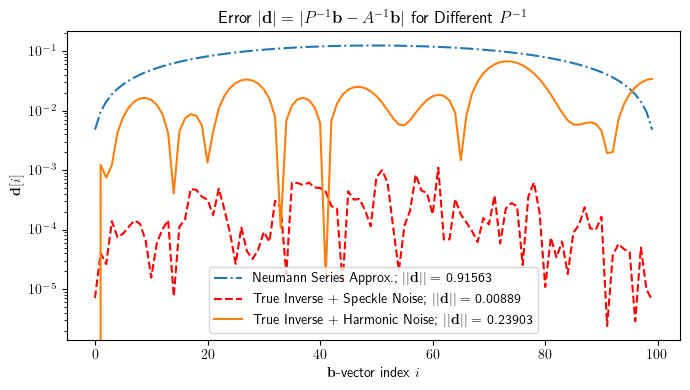

In [544]:
fig, ax = plt.subplots(1,4, figsize = (10, 3))
im0 = ax[0].imshow(Ainv)
ax[0].set_title('True Inverse')
im1 = ax[1].imshow(P_nm)
ax[1].set_title('4-term Neumann \n Series Approx.')
im2 = ax[2].imshow(P_noise)
ax[2].set_title('True Inverse \n + Speckle Noise')
im3 = ax[3].imshow(P_sines)
ax[3].set_title('True Inverse \n + Harmonic Noise')

# Add colorbars
cbar_ax0 = fig.add_axes([ax[0].get_position().x0, 0.1, ax[0].get_position().width, 0.02])  # x, y, width, height
cbar_ax1 = fig.add_axes([ax[1].get_position().x0, 0.1, ax[1].get_position().width, 0.02])
cbar_ax2 = fig.add_axes([ax[2].get_position().x0, 0.1, ax[2].get_position().width, 0.02])
cbar_ax3 = fig.add_axes([ax[3].get_position().x0, 0.1, ax[3].get_position().width, 0.02])

fig.colorbar(im0, cax=cbar_ax0, orientation='horizontal')
fig.colorbar(im1, cax=cbar_ax1, orientation='horizontal')
fig.colorbar(im2, cax=cbar_ax2, orientation='horizontal')
fig.colorbar(im3, cax=cbar_ax3, orientation='horizontal')

#plt.tight_layout()
plt.savefig(plotdir+'inverse_ims.pdf', bbox_inches = 'tight')


fig1, ax1 = plt.subplots(figsize = (7,4))
ax1.plot(abs(P_nm@np.ones(100)-np.linalg.inv(Lapl) @ np.ones(100)), '-.',
    label = r'Neumann Series Approx.; $||\mathbf{d}||=$ '+str(np.round(np.linalg.norm(P_nm@np.ones(100)-np.linalg.inv(Lapl) @ np.ones(100)), 5)))
ax1.plot(abs(P_noise@np.ones(100)-np.linalg.inv(Lapl) @ np.ones(100)), '--', color = 'red',
    label = r'True Inverse + Speckle Noise; $||\mathbf{d}||=$ '+str(np.round(np.linalg.norm(P_dense@np.ones(100)-np.linalg.inv(Lapl) @ np.ones(100)), 5)))
ax1.plot(abs(P_sines@np.ones(100)-np.linalg.inv(Lapl) @ np.ones(100)), 
    label = r'True Inverse + Harmonic Noise; $||\mathbf{d}||=$ '+str(np.round(np.linalg.norm(P_sines@np.ones(100)-np.linalg.inv(Lapl) @ np.ones(100)), 5)))
ax1.set_title(r'Error $|\mathbf{d}| = |P^{-1}\mathbf{b} - A^{-1}\mathbf{b}|$ for Different $P^{-1}$')
ax1.set_xlabel(r'$\mathbf{b}$-vector index $i$')
ax1.set_ylabel(r'$\mathbf{d}[i]$')
ax1.set_yscale('log')
ax1.legend()
plt.tight_layout()
plt.savefig(plotdir+'inverse_errors.pdf')

In [545]:
#Met Office implementation
def GCR_MO(b, its, pc=None):
    if pc is not None:
        #dx = pc(b)
        dx = np.zeros(100)
    else:
        dx = np.zeros(100)
    Ax = np.dot(dx, Lapl)
    r = b-Ax

    # set vectors up for a restart value of 150
    v = np.zeros((150, 100))
    Pv = np.zeros((150, 100))

    #array to store residuals in 
    rs = np.ones((150, 100))
    
    for iv in range(its):
        if pc is not None:
            # apply the preconditioner
            Pv[iv] = pc(r)
        else:
            Pv[iv] = r
        # apply the operator
        v[iv] = np.dot(Pv[iv], Lapl)
        #print(iv)
        for ivj in range(iv):
            alpha = v[iv].dot(v[ivj])
            #print(alpha)
            v[iv] += -alpha * v[ivj]
            Pv[iv] += -alpha * Pv[ivj]
        alpha = np.linalg.norm(v[iv])
        beta = 1.0 / alpha
        v[iv] *= beta
        Pv[iv] *= beta
        alpha = r.dot(v[iv])
        dx += alpha * Pv[iv]
        r += -alpha * v[iv]
        rs[iv] = r
    return dx, rs, Pv, v

#trying to copy from Eisenstat (1983) - this is unpreconditioned for now
def GCR_EES(b, its, pc=False):
    dx = np.zeros(100)
    Ax = np.dot(dx, Lapl)
    r = b-Ax

    # set search vectors up for a restart value of 3000
    Ap = np.zeros((3001, 100))
    p = np.zeros((3001, 100))

    #array to store residuals in 
    rs = np.ones((3000, 100))

    if pc == True:
        #p[0] = prec(r)
        p[0] = Jacobi(r)
    else:
        p[0] = r
    
    for iv in range(its):
        #print(iv)
        Ap[iv] = np.dot(p[iv], Lapl)
        #print(Ap[iv])
        a = r.dot(Ap[iv])/np.dot(Ap[iv], Ap[iv])
        #print(a)
        dx += a * p[iv]
        r += -a * Ap[iv]
        rs[iv] = r
        if pc ==True:
            #r = prec(r)
            r = Jacobi(r)
        Ar = np.dot(r, Lapl)
        for ivj in range(iv+1):
            b = - np.dot(Ar, Ap[ivj])/np.dot(Ap[ivj], Ap[ivj])
            p[iv+1] += b * p[ivj]
        p[iv+1] += r
    return dx, rs, Ap, p

In [546]:

def FabPCdiag(r):
    e = P_diag @ r
    return e

def FabPCnoise(r):
    e = P_noise @ r
    return e

def FabPCsines(r):
    e = P_sines @ r
    return e

def Jacobi(r):
    #really this is a Neumann series approximation now
    e = np.dot(r, P_nm)
    return e

In [525]:
_, _, _, _ = GCR_MO(np.ones(100), 5)

Let's run for a set number of iterations (no pc needs 51, ML pc needs 100) with and without the preconditioner to compare:

(N.B. the EES cells may be ignored, they were just for figuring things out. MO algorithm works now!)

In [526]:
sol_noprec_mo, rs_noprec_mo, Pvs_noprec_mo, v_noprec_mo = GCR_MO(np.ones(100), 51)

In [167]:
sol_noprec_mlguess, rs_noprec_mlguess, Pvs_noprec_mlguess, v_noprec_mlguess = GCR_MO(np.ones(100), 70, pc = prec)

In [547]:
sol_jac, rs_jac, Pvs_jac, v_jac = GCR_MO(np.ones(100), 100, pc=Jacobi)

In [548]:
sol_dense, rs_dense, Pvs_dense, v_dense = GCR_MO(np.ones(100), 100, pc = pc_dense)
sol_lin, rs_lin, Pvs_lin, v_lin = GCR_MO(np.ones(100), 100, pc = pc_lin)
sol_linconv, rs_linconv, Pvs_linconv, v_linconv = GCR_MO(np.ones(100), 100, pc = pc_linconv)

In [549]:
sol_fabdiag, rs_fabdiag, Pvs_fabdiag, v_fabdiag = GCR_MO(np.ones(100), 100, pc = FabPCdiag)
sol_fabsines, rs_fabsines, Pvs_fabsines, v_fabsines = GCR_MO(np.ones(100), 100, pc = FabPCsines)
sol_fabnoise, rs_fabnoise, Pvs_fabnoise, v_fabnoise = GCR_MO(np.ones(100), 100, pc = FabPCnoise)

In [452]:
sol_noprec, rs_noprec, Ap_noprec, p_noprec = GCR_EES(np.ones(100), 50)

In [ ]:
sol_prec_ees, rs_prec_ees, Ap_prec_ees, p_prec_ees = GCR_EES(np.ones(100), 10, pc=True)

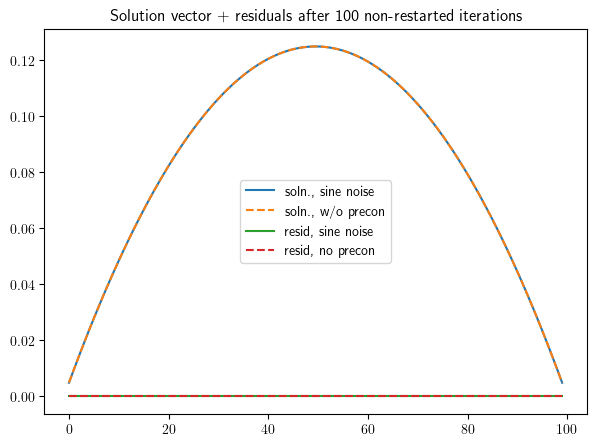

In [557]:
plt.plot(sol_linconv, label = 'soln., sine noise')
plt.plot(sol_noprec_mo, '--', label = 'soln., w/o precon')
plt.plot(rs_fabsines[1], label = 'resid, sine noise')
plt.plot(rs_noprec_mo[50], '--', label = 'resid, no precon')
plt.title('Solution vector + residuals after 100 non-restarted iterations')
plt.legend()

Okay, so we can get it to converge with an ML precon iff we do no restarts and let it iterate 100 times. In PETSc, we can reproduce this for no PC by setting the restart value to something larger than 100 (this works by passing the `-ksp_gcr_restart 60` flag), but the same does not hold for using the ML pc (still no convergence, just marginal improvement in the result). Therefore there is still something wrong with the implementation of the ML pc in PETSc.

How does the speed of convergence compare between non-preconditioned and ML-preconditioned runs? How does this compare to the PETSc solver?

In [551]:
# find L2 norms of residuals again
l2_rs_noprec = np.zeros(150)
l2_rs_jac = np.zeros(150)
l2_rs_fabsines = np.zeros(150)
l2_rs_fabdiag = np.zeros(150)
l2_rs_fabnoise = np.zeros(150)
l2_rs_dense = np.zeros(150)
for i in range(150):
    l2_rs_noprec[i] = np.linalg.norm(rs_noprec_mo[i])
    l2_rs_jac[i] = np.linalg.norm(rs_jac[i])
    l2_rs_fabsines[i] = np.linalg.norm(rs_fabsines[i])
    l2_rs_fabdiag[i] = np.linalg.norm(rs_fabdiag[i])
    l2_rs_fabnoise[i] = np.linalg.norm(rs_fabnoise[i])
    l2_rs_dense[i] = np.linalg.norm(rs_dense[i])



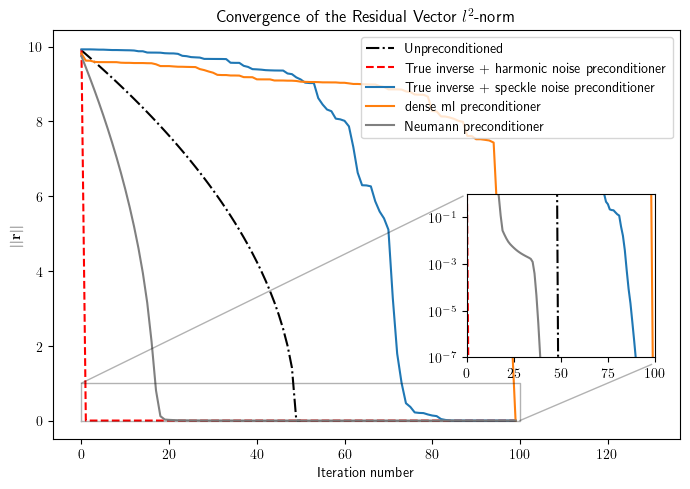

In [552]:
fig, ax = plt.subplots(figsize = (7, 5))

ax.plot(l2_rs_noprec[:51], '-.', label = 'Unpreconditioned', color = 'black')
#ax.plot(l2_rs_fabdiag[:100], label = 'Strongly diagonal approx. preconditioner')
ax.plot(l2_rs_fabsines[:100], '--', label = 'True inverse + harmonic noise preconditioner', color = 'red')
ax.plot(l2_rs_fabnoise[:100], label = 'True inverse + speckle noise preconditioner')
ax.plot(l2_rs_dense[:100], label = 'dense ml preconditioner')
ax.plot(l2_rs_jac[:100], label = 'Neumann preconditioner', color = 'grey')
#ax.plot(l2_rs_noprec_guess[:70], label = 'no pc, ML first guess')
#ax.yscale('log')
ax.set_title(r'Convergence of the Residual Vector $l^2$-norm')
ax.set_xlabel('Iteration number')
ax.set_ylabel(r'$||\mathbf{r}||$')


# Define the coordinates of the area to zoom in
x_start, x_end = 0, 100  
y_start, y_end = 1e-7, 1
# Create inset axes
ax_inset = ax.inset_axes([0.66, 0.2, 0.3, 0.4])
ax_inset.plot(range(x_start, 51), l2_rs_noprec[x_start:51], '-.', color = 'black')
ax_inset.plot(range(x_start, x_end), l2_rs_fabnoise[x_start:x_end])
ax_inset.plot(range(x_start, x_end), l2_rs_fabsines[x_start:x_end], '--', color = 'red')
ax_inset.plot(range(x_start, x_end), l2_rs_jac[x_start:x_end], color = 'grey')
ax_inset.plot(range(x_start, x_end), l2_rs_dense[x_start:x_end])
ax_inset.set_xlim(x_start, x_end)
ax_inset.set_ylim(y_start, y_end)
ax_inset.set_yscale('log')
# Add markers to indicate the area being zoomed in
ax.plot([x_start, x_start, x_end, x_end, x_start], [y_start, y_end, y_end, y_start, y_start], 'black', linewidth = 1, alpha = 0.3)
ax.plot([x_start, 87], [y_end, 6], 'black', linewidth = 1, alpha = 0.3)
ax.plot([x_end, 130], [y_start, 1.5], 'black', linewidth = 1, alpha = 0.3)

ax.legend(loc = 1)

plt.tight_layout()
plt.savefig(plotdir+'perfectprecon_conv.pdf')

Convergence without a preconditioner is very smooth, and an exact solution is found. With the ML pc, it is much more irregular. This _might_ explain why the PETSc solver still does not converge, because there could be slight differences in the implementation that then throw the solver off (doing things in a slightly different order for example - I know this is a difference between the MO code and my own Eisenstat implementation, and I think PETSc works like the Eisenstat one (although I somehow can't get prconditioning to work on that one)).

We should also note that preconditioning this problem seems really hard. Even the near-perfect preconditioner doesn't beat the unpreconditioned algorithm very clearly; it's great on the first few iterations, but then convergence kind of stalls until it kicks back into gear after 35 or so iterations. 

Playing around with the initialisation also suggests that unlike the MO GCR, the PETSc GCR does not initialise by calling the PC on the RHS, and just computes the first residual as $b-Ax$ taking $b=0$.

The behaviour of the ML emulator (i.e., inverse with harmonic noise added) is absolutely **_fascinating_** - howwwww does it converge in two iterations despite the fact its solution looks exactly like the ML model solution? And why does it converge immediately on the second iteration after not really achieving much on the first (see below)? The residual after the first iteration looks similar to that from the ML runs, but the ML residual still has a little grid-scale noise on it. Is this the entirety of the problem? Do we just need to get rid of the gridscale noise?

Despite the fact the ML preconditioner now does very well on the training data distribution, its behaviour in the solver has not improved one bit, i.e. the real-world data is too different from the training and the model does not generalise well. So we'll have another look at what the residuals actually look like in the ml-preconditioned GCR run.

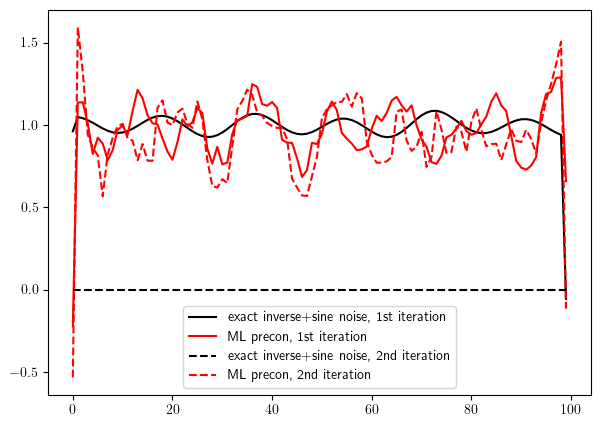

In [553]:
plt.plot(rs_fabsines[0], label = 'exact inverse+sine noise, 1st iteration', color = 'black')
plt.plot(rs_dense[0], label = 'ML precon, 1st iteration', color = 'red')
plt.plot(rs_fabsines[1],  '--', label = 'exact inverse+sine noise, 2nd iteration', color = 'black')
plt.plot(rs_dense[1],  '--', label = 'ML precon, 2nd iteration', color = 'red')
plt.legend()

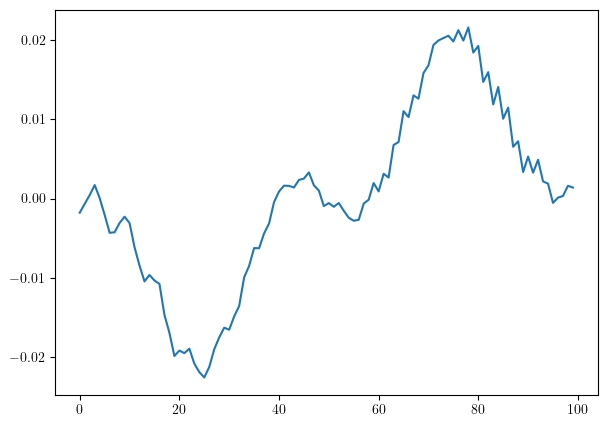

In [554]:
plt.plot(rs_linconv[98])

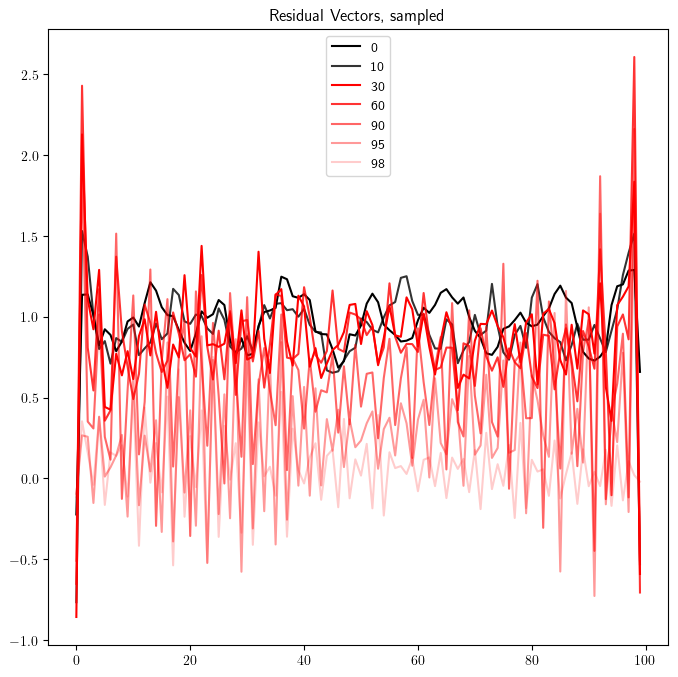

In [555]:
fig, ax = plt.subplots(figsize = (8, 8))

ax.plot(rs_dense[0], color = 'black', label = '0')
ax.plot(rs_dense[10], color = 'black', alpha = 0.8, label = '10')
ax.plot(rs_dense[30], color = 'red', label = '30')
ax.plot(rs_dense[60], color = 'red', alpha = 0.8, label = '60')
ax.plot(rs_dense[90], color = 'red', alpha = 0.6, label = '90')
ax.plot(rs_dense[95], color = 'red', alpha = 0.4, label = '95')
ax.plot(rs_dense[98], color = 'red', alpha = 0.2, label = '98')
ax.set_title('Residual Vectors, sampled')
ax.legend()

The residual decays slowly and noisily. This is all really far removed from what the model has seen during training. What about the runs with the near-perfect (but still not super good preconditioner)? Should we just train our model to emulate that?

Again, this looks really noisy. This once again poses the question whether maybe this problem is one where we should really use reinforcement learning: we want to find a preconditioner that results in the optimal solver trajectory. The residuals involved in that trajectory cannot be known a priori and hence it is almost impossible to construct an appropriate training dataset, at least if we want to make a preconditioner that just does the mapping directly rather than learning e.g. subspace augmentation. 

The only other way I can think of that would work is to use an _actually_ good preconditioner and use the search vectors constructed for that as training data. 


For reinforcement learning: On https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html, the $Q$-function describes what will happen down the line if we take a certain action. They say we need to learn this function because it is a priori unknown. Is this true in our case? Can we not predict how much the residual will decrease when the preconditioner takes a certain action? ...overall, I think DQN is probably not suitable for what I am doing here because it is challenging to define what the 'action' taken by the 'agent' is in our case. However, of course there is always the PINN-type approach taken for example by Tompson et al. (2016) and Markidis, which I _maybe_ still have time to at least start exploring? 

## Transfer learning

We have seen elsewhere that generalisation to unseen data is generally very poor. Therefore, it would make sense to include data that look like the residuals the model actually encounters at solve. However, these residuals tend to look very noisy, and from experience we know that immediately letting the model train on noisy data does not allow it to converge to a solution. Therefore, we can try doing _transfer learning_: we use pre-trained weights to initialise, but then continue training on the new dataset. 

Generating this data is a bit tricky. We know what the inout may look like, but mapping that to the desired output is hard. In our particular problem, we can do it because the exact inverse can be computed. But that's no use in the real world. However, the GCR algorithm means we are in luck: at each iteration, $v_i = Ap_i$, so we can use $v_i$ as a feature and $p_i$ as the corresponding labels. This of course assumes that those vectors are similar in their behaviour to the residual. 

To generate all those vectors, we need a whole bunch of reference solves with a variety of right-hand sides...

First, we check that $v_i$ indeed looks similar to $r$.

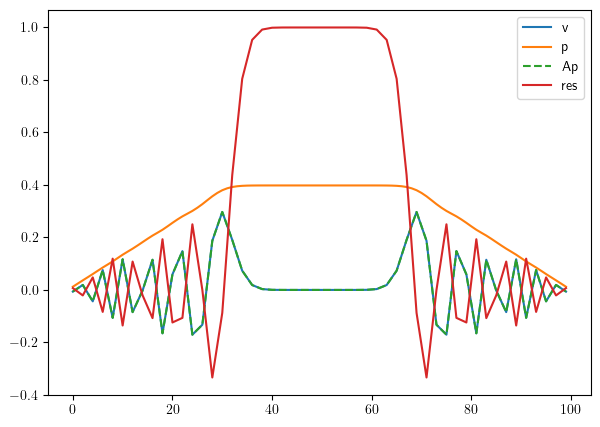

In [314]:
s = 11
plt.plot(v_jac[s], label = 'v')
plt.plot(Pvs_jac[s]*100, label = 'p')
plt.plot(Lapl @ Pvs_jac[s], '--', label = 'Ap')
plt.plot(rs_jac[s], label = 'res')
plt.legend()

They look a bit different, but similar enough in terms of frequency content. So the plan now is to perform 200 GCR solves with the Neumann preconditioner with 50 iterations each, and write all the rs and the ps to a file (after normalising them by the inf norm of v). For the right-hand sides, we use the invecs used in previous training. 

In [353]:
import os

In [354]:
file_ps = datadir + '/ps.csv'
file_vs = datadir + '/vs.csv'

if os.path.exists(file_ps):
    # If the file exists, delete its contents
    open(file_ps, 'w').close()  # This truncates the file

if os.path.exists(file_vs):
    open(file_vs, 'w').close()

for i in range(200):
    _, _, p, v = GCR_MO(vec_in[i], 50, pc = Jacobi)
    #need to truncate the arrays because everything after is just zeros
    p = p[:50]
    v = v[:50]
    #scale all vectors by the infinity norm of each v (input)
    norm = np.linalg.norm(v, np.inf, axis = 1, keepdims = True)
    p *= 1/norm
    v *= 1/norm
    with open(file_ps, 'a') as file:
        np.savetxt(file, p, delimiter=',')
    with open(file_vs, 'a') as file:
        np.savetxt(file, v, delimiter=',')

Let's just check that worked by inspecting what we wrote to those files:

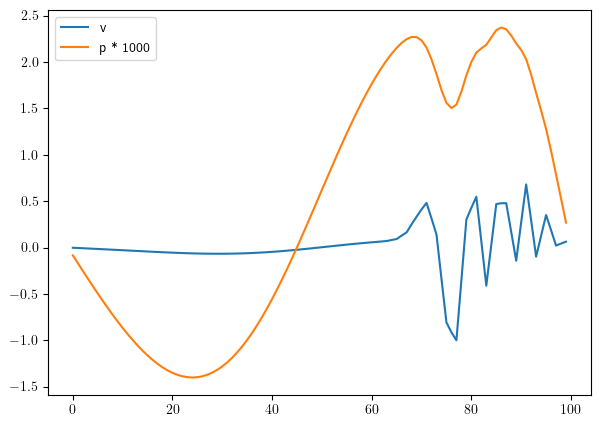

In [352]:
ps = np.loadtxt(file_ps, delimiter=',')
vs = np.loadtxt(file_vs, delimiter=',')

s = 10

plt.plot(vs[s], label = 'v')
plt.plot(ps[s] * 1000, label = 'p * 1000')
plt.legend()

## Debugging my own GCR put into PETSc

I have now translated the MO GCR defined a few cells further up into PETSc. However, it does not converge with the Jacobi preconditioner, and exits after four iterations with an error (residual norm must be nonnegative) when setting the PC to none. To work out what is happening, we repeat the analysis done on work vectors previously. 

In [ ]:
exp = 'mygcr_init/'
#jac_invecs = np.loadtxt(datadir + exp + 'prec_invecs.txt', delimiter=',')
#jac_outvecs = np.loadtxt(datadir + exp + 'prec_outvecs.txt', delimiter=',')
lapl_mygcr_invecs = np.loadtxt(datadir + exp + 'lapl_invecs.txt', delimiter=',')
lapl_mygcr_outvecs = np.loadtxt(datadir + exp + 'lapl_outvecs.txt', delimiter=',')

print('num. of vectors in Laplacian input file: ', len(lapl_jac_invecs))
print('num. of vectors in Laplacian output file: ', len(lapl_jac_outvecs))

L2_gcrinvecs = np.zeros(4)
for i in range(4):
    L2_gcrinvecs[i] = np.linalg.norm(lin_invecs[i])

num. of vectors in Laplacian input file:  4
num. of vectors in Laplacian output file:  4


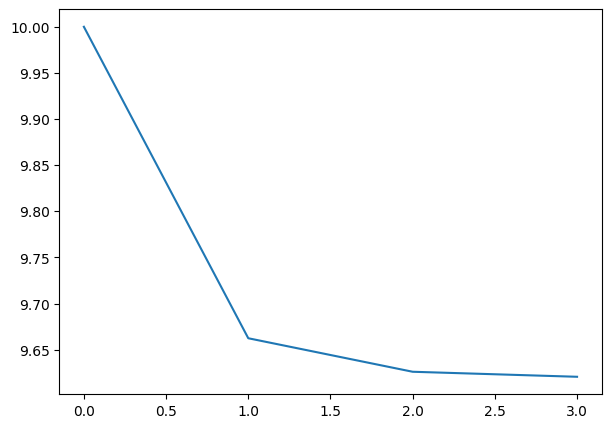

In [ ]:
plt.plot(L2_gcrinvecs)

First point: In these four iterations, convergence is not what we expect (should not flatten out). 

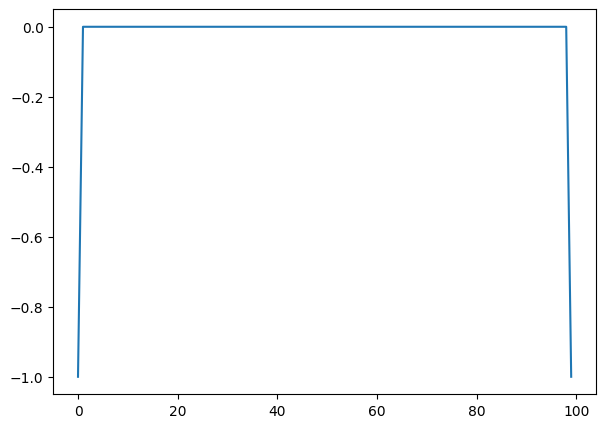

In [ ]:
plt.plot(lapl_mygcr_invecs[2]-lapl_mygcr_invecs[1])

The first iteration looks fine, but then something somehow stalls. Is data not passed around properly?

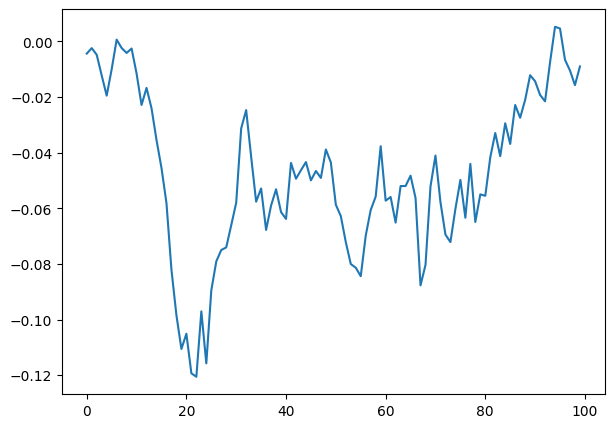

In [ ]:
#plt.plot(rs_prec_ees[1])
plt.plot(np.ones(100) - np.dot(sol_noprec_mlguess, Lapl))
#plt.plot(rs_ml[98])

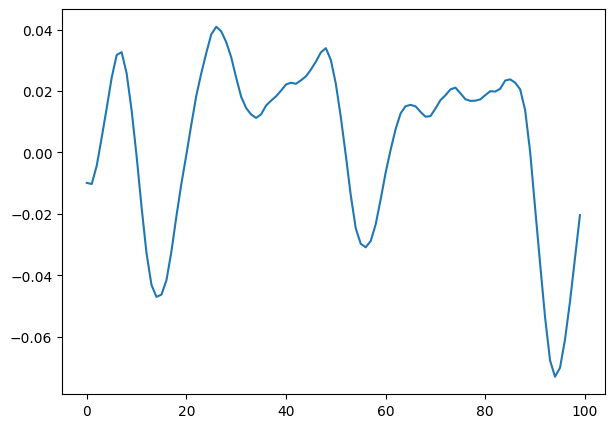

In [ ]:
plt.plot(prec(np.ones(100))-sol_noprec)

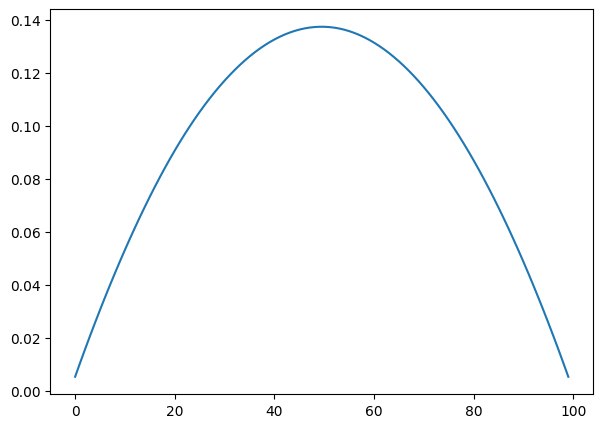

In [ ]:
plt.plot(sol_noprec_mlguess)

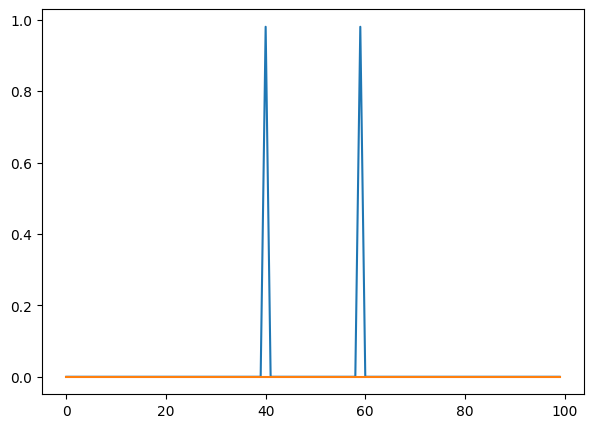

In [ ]:
it = 40
plt.plot(Ap_noprec[it]/10000)
plt.plot(Ap_prec_ees[it])

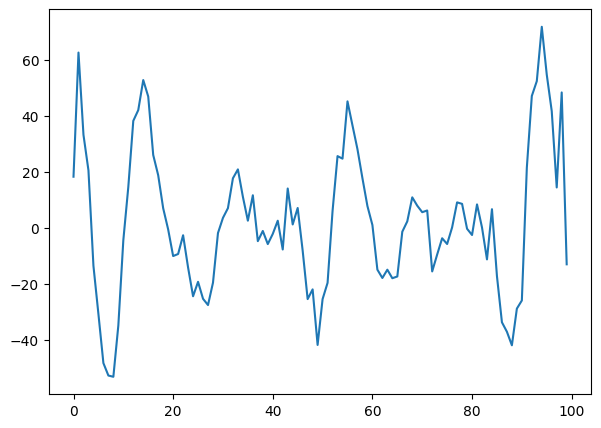

In [ ]:
plt.plot(rs_noprec_mlguess[0])

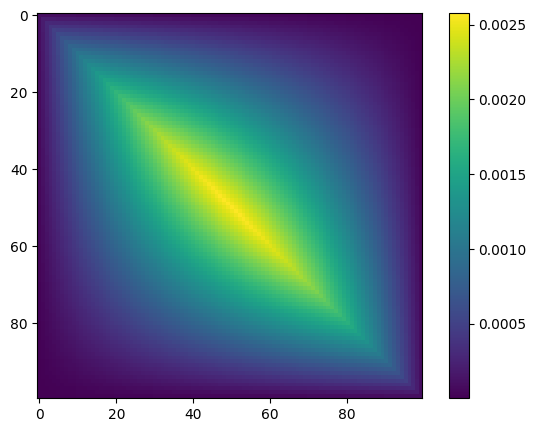

In [ ]:
plt.imshow(np.linalg.inv(Lapl))
plt.colorbar()

In [ ]:
from firedrake.petsc import PETSc

In [ ]:
e = PETSc.Vec().create(comm=PETSc.COMM_WORLD)
e.setType(PETSc.Vec.Type.STANDARD)
e.setSizes(10000,100)
e.setArray(np.zeros((100,100)))

In [ ]:
ne = e.getArray()
ne.reshape((100, 100))

e.norm()
ne = np.random.rand(4,5)
PETSc.Vec.norm(ne)

TypeError: descriptor 'norm' for 'petsc4py.PETSc.Vec' objects doesn't apply to a 'numpy.ndarray' object

In [ ]:
v = np.ones((10,10))

for i in range(10):
    v[i] *= i

t = torch.Tensor(v)

In [ ]:
torch.norm(t, dim=1).mean()

tensor(14.2302)

In [ ]:
print(range(1))

range(0, 1)


In [ ]:
for i in range(5):
    print(i)

0
1
2
3
4
